<h1>Open haloscope</h1>

<h4>Imports</h4>

In [1]:
import sys, os
import time

import numpy as np
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

<h3>Loading haloscope libraries</h3>

In [2]:
import lib.open_haloscope.experiment as experiment
from lib.open_haloscope.utils import OHUtils

In [3]:
haloscope_name = 'kakapo_haloscope'
haloscope_json = OHUtils.load_experiment_json(haloscope_name)

H = experiment.FermionicHaloscope(haloscope_json)

In [4]:
from lib.red.redpitaya_qcodes import Redpitaya
red = Redpitaya('redpitaya', address=H.experiment_parameters['redpitaya_eth0_ip'])

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.41s


<h3>Initialise and characterise the experiment</h3>

In [5]:
H.initialise_haloscope([red])

Loading instrumentation
  redpitaya added to the experiment

Setup the radiofrequency lines
 input gain set to LV
 trigger level = 0.0 V, decimation = 4
 resulting sampling frequency = 31.25 MHz
 buffer length = 16384 samples, i.e. 0.000524288 s
 output generators triggered, phase aligned and turned off

Starting UART communication
 testing sensors
 temperature = 298.64 K
 pressure = 1.14272 bar
 magnetic field = 2.255859375 V
 photoresistance = 0.8447265625 V
 acceleration = (0.16, -0.04, 10.4) m/s^2

Configuring data storage
 data are stored in C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-05-30
 logs are stored in C:\Users\nicol\Progetti\Open Haloscope\data\logs\2023-05-30
 QCodes station, QCodes database and logfiles configured

Haloscope initialised. Good luck, dark matter hunter.


Characterisation data
 characterisation database created in  C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-05-30

Initiating spectroscopy in the span 2.0 to 10.0 MHz.
 channel 1
Starting experimental run with id: 1. Using 'qcodes.dataset.do0d'


100%|██████████████████████████████████████████████████████████████████████████| 40020/40020 [3:23:50<00:00,  3.27it/s]


 channel 2
Starting experimental run with id: 2. Using 'qcodes.dataset.do0d'


100%|██████████████████████████████████████████████████████████████████████████| 40020/40020 [3:24:37<00:00,  3.26it/s]


Initiating sensors stability check for 1000 s
 temperature
Starting experimental run with id: 3. Using 'qcodes.dataset.do1d'


 pressure
Starting experimental run with id: 4. Using 'qcodes.dataset.do1d'
 magnetic_field
Starting experimental run with id: 5. Using 'qcodes.dataset.do1d'
 photoresistance
Starting experimental run with id: 6. Using 'qcodes.dataset.do1d'

Haloscope parameters acquired.


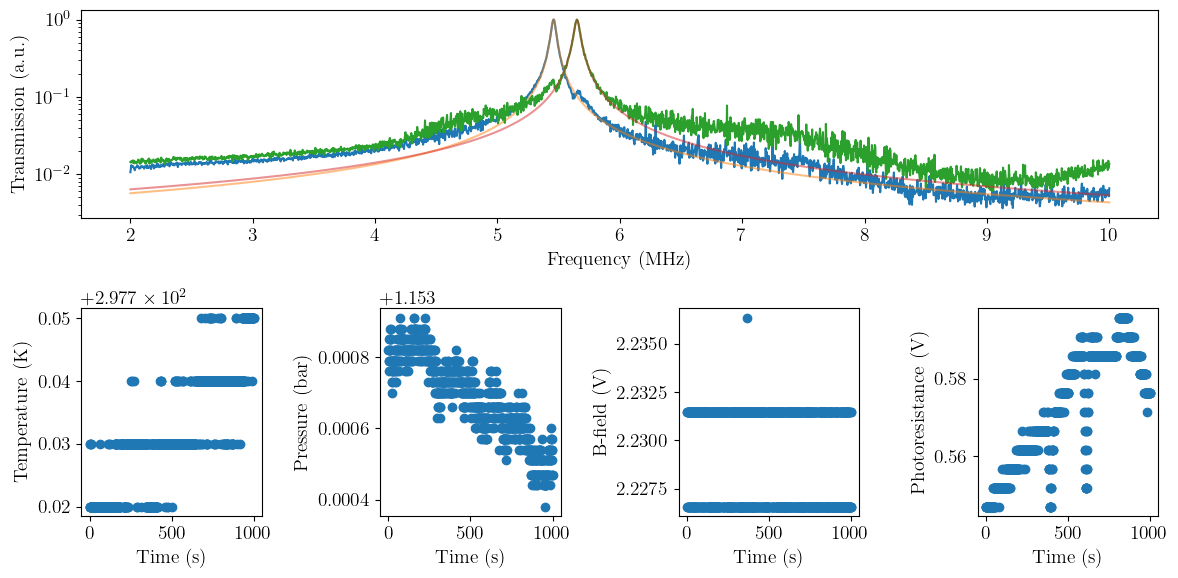

In [6]:
H.characterise(frequency_points=2001, 
               averages=20, 
               monitoring_time=1000, 
               plot=True)

In [7]:
H.experiment_parameters

{'_parameters_Kakapo': 'Parameters used in the fermionic haloscope Kakapo',
 'haloscope_name': 'kakapo',
 'f0': 5500000.0,
 'Q': 100,
 'f1': 5458563.562554126,
 'k1': 19539.16827274461,
 'f2': 5649784.559627773,
 'k2': 23458.420040699708,
 'An': 1e-08,
 'Ap': 1.0,
 'beta1': 1,
 'beta2': 1,
 'operating_frequency': 'MHz',
 'material_used': 'NiZn ferrite',
 'data_path': 'Open Haloscope\\data\\runs\\',
 'logs_path': 'Open Haloscope\\data\\logs\\',
 'redpitaya_eth0_ip': 'TCPIP::169.254.33.148::5000::SOCKET',
 'redpitaya_wlan_ip': 'TCPIP::192.168.1.30::5000::SOCKET'}

In [8]:
H.update_json_file(haloscope_json, H.experiment_parameters)

<h3>Haloscope operation</h3>
Before running this part, check that the inputs of the redpitaya are switched to HV, since the input signal is going to be large, and will otherwise saturate the ADC.

In [6]:
amplitude_gen_1 = 1 # volt
amplitude_gen_2 = 1 # volt

H.prepare_for_operation(a1=amplitude_gen_1, a2=amplitude_gen_2)

Preparing generators
 frequency of output 1 set to 5.458563562554126 MHz
 amplitude of output 1 set to 1 V
 frequency of output 2 set to 5.649784559627773 MHz
 amplitude of output 2 set to 1 V

 generators setup for operation and turned off.

Preparing acquisition
 input 1 gain set to HV
 input 2 gain set to HV
 the sampling frequency is 31.25 MHz

 calibrating the duty cycle
 the resulting duty cycle is 0.004490670481703553
 input channels configured

Haloscope ready for research.


In [ ]:
run_time = 5000 # seconds
data_saver_periodicity = 10 # seconds

H.run(run_time, data_saver_periodicity)

Starting RUN_6
 run database created in C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-05-30

Initiating data acquisition
 f1 = 5458560.0 MHz 	f2 = 5649780.0 MHz
 a1 = 1.0 V 		a2 = 1.0 V

 outputs on

 estimated number of waveforms per data block: 43
 estimated number of data blocks: 500


  3%|██▎                                                                            | 15/500 [02:56<1:34:57, 11.75s/it]

<h3>Run analysis</h3>

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**10
num = 0

ax[0].plot(data[num, n_start:n_stop])

f = periodogram(data[num, n_start:n_stop], fs=fs)[0]
rbw = f[1] - f[0]
m = rbw * periodogram(data[num, n_start:n_stop], window='hann', fs=fs)[1]
ax[1].semilogy(f, m)

<h3>Physics</h3>